In [37]:
import pandas as pd
import numpy as np
import os
import shutil

In [38]:
# Define paths
datadir = r'D:\Luminar DSML\AI Art Authenticity Detector Implementation Project\data'
train_csv = os.path.join(datadir, 'train.csv')
train_dir = os.path.join(datadir, 'train_data')
output_train_dir = os.path.join(datadir, 'organized_train')

In [ ]:
# Create output directories
os.makedirs(os.path.join(output_train_dir, 'ai_generated'), exist_ok=True)
os.makedirs(os.path.join(output_train_dir, 'human_created'), exist_ok=True)

In [40]:
# Read and prepare dataframe
train_df = pd.read_csv(train_csv)
if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop('Unnamed: 0', axis=1)

In [41]:
# Add .jpg extension if filenames don't have it
train_df['file_name'] = train_df['file_name'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')

In [42]:
# Move images to respective folders
for _, row in train_df.iterrows():
    filename = row['file_name']  
    label = row['label']
    
    # Correct source path (remove duplicate 'train_data')
    src_path = os.path.join(datadir, 'train_data', filename.split('/')[-1])
    
    if label == 1:
        dst_path = os.path.join(output_train_dir, 'ai_generated', filename.split('/')[-1])
    else:
        dst_path = os.path.join(output_train_dir, 'human_created', filename.split('/')[-1])
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"Image not found: {src_path}")

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
# defining paths

train_dir = os.path.join(datadir,'organized_train')
test_dir  = os.path.join(datadir,'test_data_v2')

In [52]:
import tensorflow as tf
# Image parametes
img_size = (224,224)
batch_size = 32
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
# training data generator along with augmenting
train_datagen = ImageDataGenerator( rescale = 1./255,rotation_range = 20,width_shift_range = 0.2,height_shift_range = 0.2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,fill_mode='nearest',validation_split = 0.2)
    

In [54]:
# validation and testing data generator only rescaling is done

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [55]:
# now creating generators

train_generator = train_datagen.flow_from_directory(train_dir,target_size=img_size,batch_size=batch_size,class_mode='binary',subset='training',classes=['human_created','ai_generated'],seed=42)
validation_generator = val_datagen.flow_from_directory(train_dir,target_size=img_size,batch_size=batch_size,class_mode='binary',subset='validation',classes=['human_created','ai_generated'],seed=42)

#now for testing data which has no labels
test_generator = test_datagen.flow_from_directory(directory=datadir,classes=['test_data_v2'],target_size=img_size,batch_size=batch_size,class_mode=None,shuffle=False)

Found 63960 images belonging to 2 classes.
Found 15990 images belonging to 2 classes.
Found 5540 images belonging to 1 classes.


In [56]:
print(train_generator.class_indices)
# Will output: {'ai_generated': 0, 'human_created': 1} 
# # in actual data the labels are vice versa so it should be considered after trainign and when predicting

{'human_created': 0, 'ai_generated': 1}


In [58]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [59]:
# loading ResNet50 base model (which is already pretrained on ImageNet)

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

# freezed base layers
base_model.trainable = False

# added custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x) #regularization
predictions = Dense(1,activation='sigmoid')(x) #binary output

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [61]:
# final model
model = Model(inputs=base_model.input,outputs=predictions)

In [62]:
# compile metrics

model.compile(optimizer = Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

In [63]:
# callbacks
callbacks = [EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)]

In [64]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)

c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7592 - loss: 0.4969 - precision: 0.7777 - recall: 0.7241

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3277s 2s/step - accuracy: 0.7592 - loss: 0.4969 - precision: 0.7778 - recall: 0.7241 - val_accuracy: 0.7926 - val_loss: 0.4553 - val_precision: 0.7558 - val_recall: 0.8647
Epoch 2/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8056 - loss: 0.4327 - precision: 0.8267 - recall: 0.7706

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3183s 2s/step - accuracy: 0.8056 - loss: 0.4327 - precision: 0.8267 - recall: 0.7706 - val_accuracy: 0.8083 - val_loss: 0.4301 - val_precision: 0.7775 - val_recall: 0.8637
Epoch 3/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8154 - loss: 0.4162 - precision: 0.8378 - recall: 0.7825

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3258s 2s/step - accuracy: 0.8154 - loss: 0.4162 - precision: 0.8378 - recall: 0.7825 - val_accuracy: 0.8145 - val_loss: 0.4210 - val_precision: 0.7862 - val_recall: 0.8640
Epoch 4/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8229 - loss: 0.4046 - precision: 0.8424 - recall: 0.7968

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3665s 2s/step - accuracy: 0.8229 - loss: 0.4046 - precision: 0.8424 - recall: 0.7968 - val_accuracy: 0.8259 - val_loss: 0.3947 - val_precision: 0.8130 - val_recall: 0.8464
Epoch 5/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3367s 2s/step - accuracy: 0.8243 - loss: 0.4006 - precision: 0.8421 - recall: 0.7978 - val_accuracy: 0.8122 - val_loss: 0.4243 - val_precision: 0.7666 - val_recall: 0.8977
Epoch 6/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2811s 1s/step - accuracy: 0.8261 - loss: 0.3948 - precision: 0.8426 - recall: 0.8058 - val_accuracy: 0.8233 - val_loss: 0.3927 - val_precision: 0.7945 - val_recall: 0.8722
Epoch 7/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3111s 2s/step - accuracy: 0.8273 - loss: 0.3926 - precision: 0.8415 - recall: 0.8073 - val_accuracy: 0.8099 - val_loss: 0.4265 - val_precision: 0.7578 - val_recall: 0.9111
Epoch 8/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8242 - loss: 0.3940 - precision: 0.8387 - recall: 0.8038

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2845s 1s/step - accuracy: 0.8242 - loss: 0.3940 - precision: 0.8387 - recall: 0.8038 - val_accuracy: 0.8348 - val_loss: 0.3728 - val_precision: 0.8238 - val_recall: 0.8517
Epoch 9/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2721s 1s/step - accuracy: 0.8283 - loss: 0.3882 - precision: 0.8425 - recall: 0.8052 - val_accuracy: 0.8241 - val_loss: 0.3975 - val_precision: 0.7841 - val_recall: 0.8947
Epoch 10/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3289s 2s/step - accuracy: 0.8311 - loss: 0.3869 - precision: 0.8420 - recall: 0.8131 - val_accuracy: 0.8236 - val_loss: 0.3967 - val_precision: 0.7803 - val_recall: 0.9007
Epoch 11/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3665s 2s/step - accuracy: 0.8312 - loss: 0.3834 - precision: 0.8438 - recall: 0.8095 - val_accuracy: 0.8280 - val_loss: 0.3841 - val_precision: 0.7898 - val_recall: 0.8939
Epoch 12/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2806s 1s/step - accuracy: 0.8353 - loss: 0.3785 - precision: 0.8455 - recall: 0.8201 - val_accuracy: 0.8279 - 

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3061s 2s/step - accuracy: 0.8364 - loss: 0.3730 - precision: 0.8485 - recall: 0.8211 - val_accuracy: 0.8400 - val_loss: 0.3625 - val_precision: 0.8230 - val_recall: 0.8663
Epoch 14/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 3131s 2s/step - accuracy: 0.8369 - loss: 0.3753 - precision: 0.8484 - recall: 0.8195 - val_accuracy: 0.8373 - val_loss: 0.3667 - val_precision: 0.8085 - val_recall: 0.8839
Epoch 15/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2818s 1s/step - accuracy: 0.8385 - loss: 0.3725 - precision: 0.8491 - recall: 0.8228 - val_accuracy: 0.8338 - val_loss: 0.3734 - val_precision: 0.8014 - val_recall: 0.8876
Epoch 16/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2808s 1s/step - accuracy: 0.8348 - loss: 0.3746 - precision: 0.8454 - recall: 0.8190 - val_accuracy: 0.8236 - val_loss: 0.3909 - val_precision: 0.7761 - val_recall: 0.9098
Epoch 17/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8361 - loss: 0.3731 - precision: 0.8445 - recall: 0.8236

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2852s 1s/step - accuracy: 0.8361 - loss: 0.3731 - precision: 0.8445 - recall: 0.8236 - val_accuracy: 0.8442 - val_loss: 0.3549 - val_precision: 0.8370 - val_recall: 0.8548
Epoch 18/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2811s 1s/step - accuracy: 0.8384 - loss: 0.3736 - precision: 0.8505 - recall: 0.8204 - val_accuracy: 0.8388 - val_loss: 0.3622 - val_precision: 0.8085 - val_recall: 0.8879
Epoch 19/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2855s 1s/step - accuracy: 0.8386 - loss: 0.3697 - precision: 0.8484 - recall: 0.8255 - val_accuracy: 0.8255 - val_loss: 0.3939 - val_precision: 0.7775 - val_recall: 0.9121
Epoch 20/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 2979s 1s/step - accuracy: 0.8395 - loss: 0.3703 - precision: 0.8491 - recall: 0.8254 - val_accuracy: 0.8348 - val_loss: 0.3655 - val_precision: 0.7968 - val_recall: 0.8987


In [65]:
# Save final model (modern format)
model.save('art_authenticity_model.keras')  # Changed from .h5 to .keras

# Optionally save in both formats for compatibility
model.save('art_authenticity_model.h5')  # Keep this if you need backward compatibility

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [69]:
# 1. Evaluate on Validation Set (since test set has no labels)
print("\nEvaluating on validation set...")
val_loss, val_acc, val_precision, val_recall = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")


Evaluating on validation set...
500/500 ━━━━━━━━━━━━━━━━━━━━ 1109s 2s/step - accuracy: 0.8404 - loss: 0.3612 - precision: 0.8298 - recall: 0.8505
Validation Accuracy: 0.8442
Validation Precision: 0.8370
Validation Recall: 0.8548


In [70]:
# Generate predictions for validation set (for confusion matrix)
validation_generator.reset()
val_preds = model.predict(validation_generator, verbose=1)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions

500/500 ━━━━━━━━━━━━━━━━━━━━ 1052s 2s/step


In [71]:
# Get true labels
val_true = validation_generator.classes

In [72]:
# Classification report
print("\nClassification Report:")
print(classification_report(val_true, val_preds, target_names=['human_created', 'ai_generated']))


Classification Report:
               precision    recall  f1-score   support

human_created       0.50      0.49      0.49      7995
 ai_generated       0.50      0.51      0.50      7995

     accuracy                           0.50     15990
    macro avg       0.50      0.50      0.50     15990
 weighted avg       0.50      0.50      0.50     15990



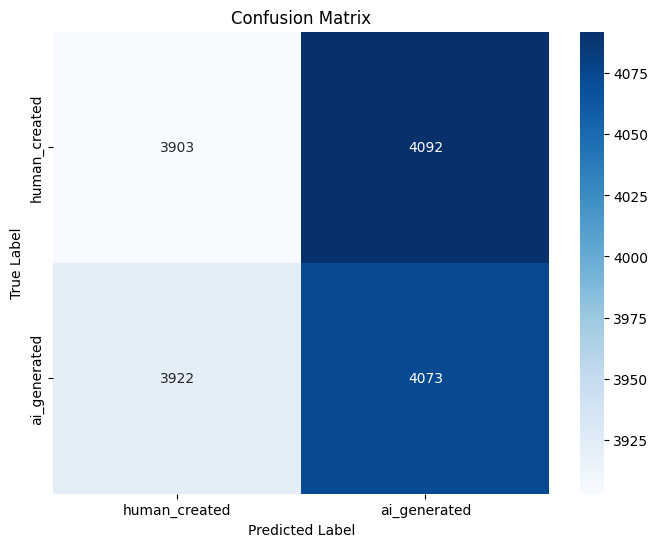

In [73]:
# Confusion matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['human_created', 'ai_generated'],
            yticklabels=['human_created', 'ai_generated'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

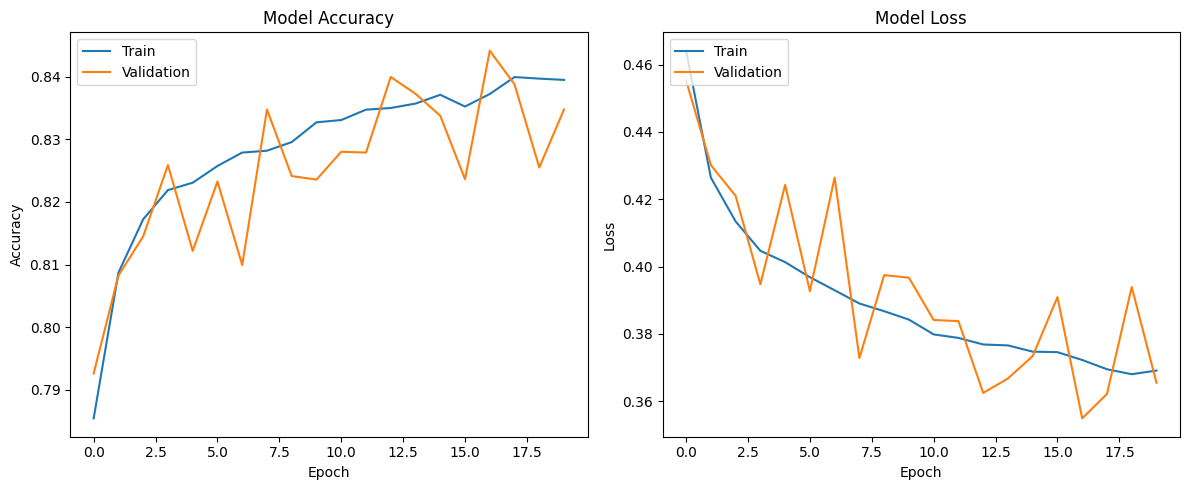

In [74]:
#  Plot Training History
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [75]:
# Generate predictions for test set (since we don't have labels)
test_generator.reset()
test_preds = model.predict(test_generator, verbose=1)
test_preds = (test_preds > 0.5).astype(int)  # Convert to binary predictions



c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step


In [76]:
# Create submission file
test_files = test_generator.filenames
submission = pd.DataFrame({
    'id': [os.path.splitext(f)[0] for f in test_files],
    'label': test_preds.flatten()
})

In [77]:
submission.to_csv('submission.csv', index=False)
print("\nTest predictions saved to submission.csv")


Test predictions saved to submission.csv


In [100]:
from tensorflow.keras.preprocessing import image

def predict_image(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to match training
    
    # Make prediction
    prediction = model.predict(img_array)
    prob = prediction[0][0]
    
    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    
    if prob > 0.5:
        plt.title(f"AI Generated ({prob*100:.2f}% confidence)", color='red')
    else:
        plt.title(f"Human Created ({(1-prob)*100:.2f}% confidence)", color='green')
    
    plt.show()
    
    return prob



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


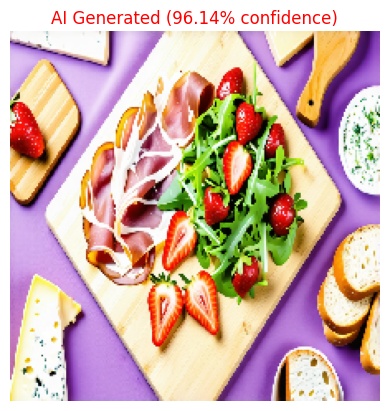

Prediction confidence score: 0.9614


In [103]:
# Usage example:
# Replace 'path_to_your_image.jpg' with your actual image path
image_path = r'D:\Luminar DSML\AI Art Authenticity Detector Implementation Project\data\test_data_v2\fdec8b58fd934ac08b344f45108e5006.jpg'
confidence_score = predict_image(image_path)
print(f"Prediction confidence score: {confidence_score:.4f}")